In [182]:
import numpy as np
import tifffile
from glob import glob
import napari
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage.measure import regionprops_table
import pandas as pd
import seaborn as sns
from sklearn.metrics import jaccard_score, precision_score, recall_score

In [107]:
image_stack = np.zeros((100,256,46))
true_mask_stack= np.zeros((100,256,46))

In [108]:
img_dirs = glob("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/delta_hist_mid_large/convolutions/*.tif")
mask_dirs = glob("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/delta_hist_mid_large/masks/*.tif")

In [109]:
for x in range(0,100):
    image_stack[x,:,:] = tifffile.imread(img_dirs[x+1000])
    true_mask_stack[x,:,:] = tifffile.imread(mask_dirs[x+1000])

In [110]:
tifffile.imsave("image_stack.tif",image_stack)
tifffile.imsave("true_mask_stack.tif",image_stack)

In [136]:
viewer = napari.view_image(image_stack)
mask_layer = viewer.add_labels(np.zeros((100,256,46)).astype(int), name = "mask_layer")

/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [153]:
viewer = napari.view_image(label(true_mask_stack,connectivity=1))


/home/georgeos/anaconda3/envs/SYMPTOMM/lib/python3.8/site-packages/napari/_vispy/vispy_camera.py:109: RuntimeWarning: divide by zero encountered in true_divide
  zoom = np.min(canvas_size / scale)


In [35]:
#tifffile.imsave("mask_layer.tif",mask_layer.data)

2361

In [113]:
human_masks = tifffile.imread("human_vs_SyMBac/mask_layer_somenath.tif")

In [161]:
lengths = []
widths = []
areas=[]
for x in range(30):
    df = pd.DataFrame(regionprops_table(label(human_masks[x],connectivity=1),properties = ["major_axis_length","minor_axis_length","area"]))
    lengths.extend(list(df["major_axis_length"]))
    widths.extend(list(df["minor_axis_length"]))
    areas.extend(list(df["area"]))

In [162]:
true_lengths = []
true_widths = []
true_areas=[]
for x in range(30):
    df = pd.DataFrame(regionprops_table(label(true_mask_stack[x],connectivity=1),properties = ["major_axis_length","minor_axis_length","area"]))
    true_lengths.extend(list(df["major_axis_length"]))
    true_widths.extend(list(df["minor_axis_length"]))
    true_areas.extend(list(df["area"]))

In [163]:
print(np.mean(lengths))
print(np.mean(true_lengths))

74.68585632288467
79.21498910977301


In [164]:
print(np.mean(widths))
print(np.mean(true_widths))

14.094170711625514
16.16133478783485


In [165]:
print(np.var(areas)/(np.mean(areas)**2))
print(np.var(true_areas)/(np.mean(true_areas)**2))

0.09840462791670504
0.06392701431966046


In [166]:
def normalised_variance(l):
    return np.var(l)/(np.mean(l)**2)

In [167]:
for l in [lengths,widths,areas]:
    print(normalised_variance(l))

0.07469451344448724
0.006693362723952835
0.09840462791670504


In [168]:
for l in [true_lengths,true_widths,true_areas]:
    print(normalised_variance(l))

0.06219356448772424
0.0014845120062014778
0.06392701431966046


In [183]:
jaccards = []
for x in range(30):
    jaccards.append(jaccard_score(true_mask_stack[x].flatten(), human_masks[x].flatten()))
    
precisions = []
for x in range(30):
    precisions.append(precision_score(true_mask_stack[x].flatten(), human_masks[x].flatten()))
    
recalls = []
for x in range(30):
    recalls.append(recall_score(true_mask_stack[x].flatten(), human_masks[x].flatten()))

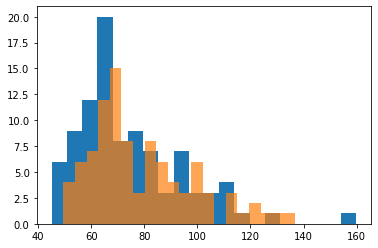

In [171]:
plt.hist(lengths,bins=20)
plt.hist(true_lengths,bins=20,alpha=0.7)

plt.show()

Text(0, 0.5, 'Human measured length (pixels)')

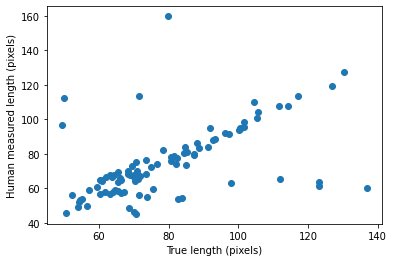

In [172]:
plt.scatter(true_lengths,lengths)
plt.xlabel("True length (pixels)")
plt.ylabel("Human measured length (pixels)")

(10.0, 17.59688155157915)

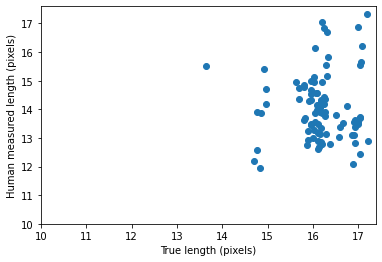

In [160]:
plt.scatter(true_widths,widths)
plt.xlabel("True length (pixels)")
plt.ylabel("Human measured length (pixels)")
plt.xlim(10,)
plt.ylim(10,)

Text(0, 0.5, 'Human measured area (pixels)')

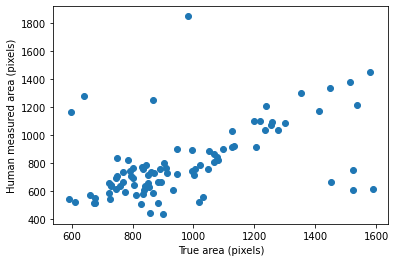

In [157]:
plt.scatter(true_areas,areas)
plt.xlabel("True area (pixels)")
plt.ylabel("Human measured area (pixels)")

In [243]:
metrics = pd.DataFrame()
metrics["Recall"] = recalls
metrics["Precision"] = precisions
metrics["IoU"] = jaccards
metrics = metrics.melt()
metrics.columns = ["Metric", "Value"]
metrics.to_pickle("metrics_exponential.pickle")

Text(0.5, 0, '')

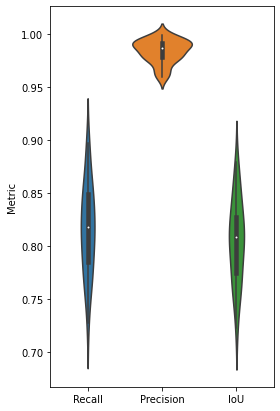

In [242]:
plt.figure(figsize=(4,7))
sns.violinplot(data=metrics,x="Metric",y="Value")
plt.ylabel("Metric")
plt.xlabel("")

In [207]:
width_error = (np.array(widths)-np.array(true_widths))/np.array(true_widths)
length_error = (np.array(lengths)-np.array(true_lengths))/np.array(true_lengths)
area_error = (np.array(areas)-np.array(true_areas))/np.array(true_areas)

In [248]:
morphologies = pd.DataFrame()
morphologies["Width"] = width_error*100
morphologies["Length"] = length_error*100
#morphologies["Area % error"] = area_error*100
morphologies = morphologies.melt()
morphologies.columns = ["Error", "Value"]
morphologies = morphologies[morphologies["Value"] < 40]
morphologies = morphologies[morphologies["Value"] > -30]
morphologies.to_pickle("morphologies_exponential.pickle")

In [250]:
morphologies["Error"].unique()

array(['Width', 'Length'], dtype=object)

<AxesSubplot:xlabel='Error', ylabel='Value'>

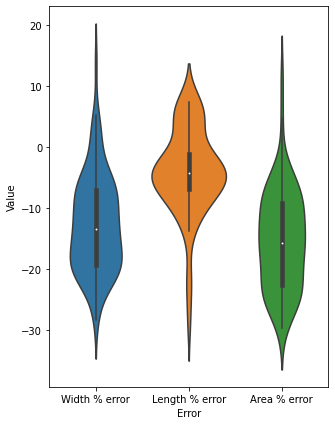

In [240]:
plt.figure(figsize=(5,7))
sns.violinplot(data=morphologies,x="Error",y="Value")

<AxesSubplot:xlabel='Error', ylabel='Value'>

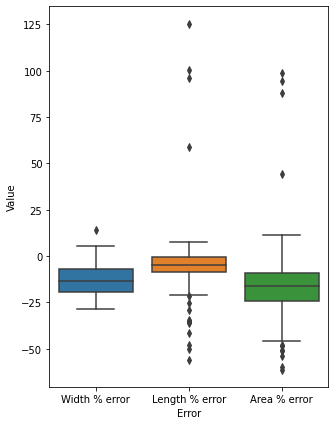

In [232]:
morphologies = pd.DataFrame()
morphologies["Width % error"] = width_error*100
morphologies["Length % error"] = length_error*100
morphologies["Area % error"] = area_error*100
morphologies = morphologies.melt()
morphologies.columns = ["Error", "Value"]
plt.figure(figsize=(5,7))
sns.boxplot(data=morphologies,x="Error",y="Value")